In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 32.8 MB/s 
     |████████████████████████████████| 636 kB 42.2 MB/s 
     |████████████████████████████████| 50 kB 3.4 MB/s 
     |████████████████████████████████| 895 kB 56.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=09c6caef4e69024bd9bc086805d04481b7b1fa2b3bf262501c5948465893857e
  Stored in directory: /tmp/pip-ephem-wheel-cache-9fmv3ul8/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
!ls drive/MyDrive/model/bert_med/checkpoint/checkpoint-final

ls: cannot access 'drive/MyDrive/model/bert_med/checkpoint/checkpoint-final': No such file or directory


In [ ]:
question = "Can you give dosage information acetaminophen for children?"

reply = """Use acetaminophen exactly as directed on the label, or as prescribed by your doctor. Do not use in larger or smaller amounts or for longer than recommended.
Do not take more of this medication than is recommended. An overdose of acetaminophen can damage your liver or cause death.
Adults and teenagers who weigh at least 110 pounds (50 kilograms): Do not take more than 1000 milligrams (mg) at one time. Do not take more than 4000 mg in 24 hours.
Children younger than 12 years old: Do not take more than 5 doses of acetaminophen in 24 hours. Use only the number of milligrams per dose that is recommended for the child's weight and age. Use exactly as directed on the label.
Avoid also using other medicines that contain acetaminophen, or you could have a fatal overdose.
If you are treating a child, use a pediatric form of acetaminophen. Use only the special dose-measuring dropper or oral syringe that comes with the specific pediatric form you are using. Carefully follow the dosing directions on the medicine label.
Measure liquid medicinewith the dosing syringe provided, or with a special dose-measuring spoon or medicine cup. If you do not have a dose-measuring device, ask your pharmacist for one.
Acetaminophen made for infants is available in two different dose concentrations, and each concentration comes with its own medicine dropper or oral syringe. These dosing devices are not equal between the different concentrations. Using the wrong device may cause you to give your child an overdose of acetaminophen. Never mix and match dosing devices between infant formulations of acetaminophen.
You may need to shake the liquid before each use. Follow the directions on the medicine label.
The chewable tablet must be chewed thoroughly before you swallow it.
Make sure your hands are dry when handling the acetaminophen disintegrating tablet. Place the tablet on your tongue. It will begin to dissolve right away. Do not swallow the tablet whole. Allow it to dissolve in your mouth without chewing.
To use the acetaminophen effervescent granules, dissolve one packet of the granules in at least 4 ounces of water. Stir this mixture and drink all of it right away. To make sure you get the entire dose, add a little more water to the same glass, swirl gently and drink right away.
The oral powder should be placed directly on the tongue and swallowed.
Stop taking acetaminophen and call your doctor if:
you still have a sore throat after 2 days of use;
you still have a fever after 3 days of use;
you still have pain after 7 days of use (or 5 days if treating a child);
you have a skin rash, ongoing headache, nausea, vomiting, or any redness or swelling; or
if your symptoms get worse, or if you have any new symptoms.
This medication can cause unusual results with certain lab tests for glucose (sugar) in the urine. Tell any doctor who treats you that you are using acetaminophen.
Store at room temperature away from heat and moisture.
Detailed Acetaminophen dosage information
What happens if I miss a dose?
Since acetaminophen is taken as needed, you may not be on a dosing schedule. If you are taking the medication regularly, take the missed dose as soon as you remember. Skip the missed dose if it is almost time for your next scheduled dose. Do not take extra medicine to make up the missed dose.
What happens if I overdose?
Seek emergency medical attention or call the Poison Help line at 1-800-222-1222. An overdose of acetaminophen can be fatal.
The first signs of an acetaminophen overdose include loss of appetite, nausea, vomiting, stomach pain, sweating, and confusion or weakness. Later symptoms may include pain in your upper stomach, dark urine, and yellowing of your skin or the whites of your eyes.
"""

In [ ]:
class SentenceSimilarity():
    def __init__(self, model_name=None, device='cuda'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).eval()

    def __call__(self, text):
        tokens = self.tokenizer(text, padding=True, return_tensors='pt', truncation=True)
        with torch.no_grad():
            embeddings = self.model(**tokens).last_hidden_state

        mask = tokens['attention_mask'].unsqueeze(-1).expand(embeddings.shape).float()
        sentence_embeddings = torch.sum(embeddings * mask, dim=1) / torch.clamp(mask.sum(1), min=1e-9) 
        return sentence_embeddings

    def compute_label_embedding(self, labels):
        self.label_embeds = self(labels)
    
    def similarity(self, example):
        return torch.cosine_similarity(self(example), self.label_embeds).tolist()

In [ ]:
from transformers import AutoTokenizer, AutoModel
import en_core_web_lg
import torch
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
nlp = en_core_web_lg.load()
doc = nlp(reply)
labels = [str(sentence) for sentence in list(doc.sents)]
examples = [question]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_base_name = 'drive/MyDrive/bert-base-finetuned'
model_base = SentenceSimilarity(model_base_name)
model_base.compute_label_embedding(labels)

Some weights of the model checkpoint at drive/MyDrive/bert-base-finetuned were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at drive/MyDrive/bert-base-finetuned and are newly initialized: ['bert.pooler.dense.bias', 'be

In [ ]:
scores = model_base.similarity(examples[0])
dic = {}

print(question)

for i, ex in enumerate(labels):
    dic[ex] = scores[i]

s = pd.Series(dic, name='Similarity')
s.index.name = 'Sentences'
df_finetune_bert = s.reset_index()
df_finetune_bert.sort_values(by='Similarity', ascending=False, inplace=True)
df_finetune_bert.reset_index(inplace=True)
df_finetune_bert

Can you give dosage information acetaminophen for children?


,index,Sentences,Similarity
0,38,Detailed Acetaminophen dosage information\n,0.853427
1,19,Never mix and match dosing devices between inf...,0.833955
2,40,"Since acetaminophen is taken as needed, you ma...",0.812427
3,10,"If you are treating a child, use a pediatric f...",0.797016
4,16,Acetaminophen made for infants is available in...,0.787604
5,32,Stop taking acetaminophen and call your doctor...,0.777802
6,23,Make sure your hands are dry when handling the...,0.772180
7,36,Tell any doctor who treats you that you are us...,0.744137
8,6,Children younger than 12 years old: Do not tak...,0.731766
9,28,To use the acetaminophen effervescent granules...,0.729823


In [ ]:
model_base_name = 'bert-base-uncased'
model_base = SentenceSimilarity(model_base_name)
model_base.compute_label_embedding(labels)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
scores = model_base.similarity(examples[0])
dic = {}

print(question)

for i, ex in enumerate(labels):
    dic[ex] = scores[i]

s = pd.Series(dic, name='Similarity')
s.index.name = 'Sentences'
df_finetune_bert = s.reset_index()
df_finetune_bert.sort_values(by='Similarity', ascending=False, inplace=True)
df_finetune_bert.reset_index(inplace=True)
df_finetune_bert

Can you give dosage information acetaminophen for children?


,index,Sentences,Similarity
0,19,Never mix and match dosing devices between inf...,0.880267
1,40,"Since acetaminophen is taken as needed, you ma...",0.873089
2,38,Detailed Acetaminophen dosage information\n,0.855957
3,10,"If you are treating a child, use a pediatric f...",0.830490
4,23,Make sure your hands are dry when handling the...,0.818485
5,16,Acetaminophen made for infants is available in...,0.813781
6,0,Use acetaminophen exactly as directed on the l...,0.812985
7,6,Children younger than 12 years old: Do not tak...,0.808529
8,32,Stop taking acetaminophen and call your doctor...,0.808096
9,9,Avoid also using other medicines that contain ...,0.806899


In [ ]:
model_large_name = 'drive/MyDrive/bert-large-finetuned'
model_large = SentenceSimilarity(model_large_name)
model_large.compute_label_embedding(labels)

Some weights of the model checkpoint at drive/MyDrive/bert-large-finetuned were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at drive/MyDrive/bert-large-finetuned and are newly initialized: ['bert.pooler.dense.bias', '

In [ ]:
scores = model_large.similarity(examples[0])
dic = {}

print(question)

for i, ex in enumerate(labels):
    dic[ex] = scores[i]

s = pd.Series(dic, name='Similarity')
s.index.name = 'Sentences'
df_finetune_bert = s.reset_index()
df_finetune_bert.sort_values(by='Similarity', ascending=False, inplace=True)
df_finetune_bert.reset_index(inplace=True)
df_finetune_bert

Can you give dosage information acetaminophen for children?


,index,Sentences,Similarity
0,10,"If you are treating a child, use a pediatric f...",0.830899
1,38,Detailed Acetaminophen dosage information\n,0.830435
2,18,Using the wrong device may cause you to give y...,0.795456
3,16,Acetaminophen made for infants is available in...,0.791079
4,28,To use the acetaminophen effervescent granules...,0.761752
5,32,Stop taking acetaminophen and call your doctor...,0.756600
6,0,Use acetaminophen exactly as directed on the l...,0.755415
7,23,Make sure your hands are dry when handling the...,0.751867
8,6,Children younger than 12 years old: Do not tak...,0.749787
9,11,Use only the special dose-measuring dropper or...,0.749476


In [ ]:
model_large_name = 'bert-large-uncased'
model_large = SentenceSimilarity(model_large_name)
model_large.compute_label_embedding(labels)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
scores = model_large.similarity(examples[0])
dic = {}

print(question)

for i, ex in enumerate(labels):
    dic[ex] = scores[i]

s = pd.Series(dic, name='Similarity')
s.index.name = 'Sentences'
df_finetune_bert = s.reset_index()
df_finetune_bert.sort_values(by='Similarity', ascending=False, inplace=True)
df_finetune_bert.reset_index(inplace=True)
df_finetune_bert

Can you give dosage information acetaminophen for children?


,index,Sentences,Similarity
0,38,Detailed Acetaminophen dosage information\n,0.898420
1,19,Never mix and match dosing devices between inf...,0.893630
2,40,"Since acetaminophen is taken as needed, you ma...",0.877569
3,16,Acetaminophen made for infants is available in...,0.872395
4,10,"If you are treating a child, use a pediatric f...",0.853832
5,32,Stop taking acetaminophen and call your doctor...,0.852571
6,9,Avoid also using other medicines that contain ...,0.851332
7,36,Tell any doctor who treats you that you are us...,0.844329
8,6,Children younger than 12 years old: Do not tak...,0.841645
9,15,"If you do not have a dose-measuring device, as...",0.829827


In [ ]:
labels_vector = np.array([nlp(label).vector for label in labels])

In [ ]:
labels_vector.shape

(49, 300)

In [ ]:
pca = PCA(n_components=2)
pca.fit(labels_vector)
labels_reducted = pca.transform(labels_vector)
print(pca.explained_variance_ratio_)

[0.20346883 0.13145208]


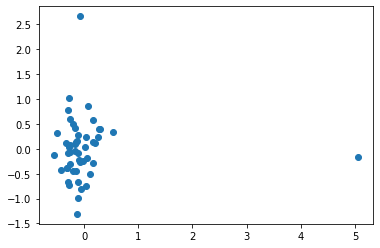

In [ ]:
plt.scatter(labels_reducted.T[0], labels_reducted.T[1])

In [ ]:
model_base_name = 'drive/MyDrive/bert-base-finetuned'
model_base = SentenceSimilarity(model_base_name)
model_base.compute_label_embedding(labels)

Some weights of the model checkpoint at drive/MyDrive/bert-base-finetuned were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at drive/MyDrive/bert-base-finetuned and are newly initialized: ['bert.pooler.dense.bias', 'be

In [ ]:
labels_vector = model_base.label_embeds
pca.fit(labels_vector)
labels_reducted = pca.transform(labels_vector)
print(pca.explained_variance_ratio_)

[0.13525368 0.11957026]


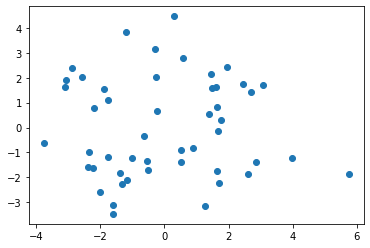

In [ ]:
plt.scatter(labels_reducted.T[0], labels_reducted.T[1])

In [ ]:
model_base_name = 'bert-base-uncased'
model_base = SentenceSimilarity(model_base_name)
model_base.compute_label_embedding(labels)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
labels_vector = model_base.label_embeds
pca.fit(labels_vector)
labels_reducted = pca.transform(labels_vector)
print(pca.explained_variance_ratio_)

[0.19288862 0.09613357]


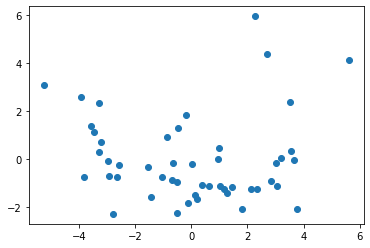

In [ ]:
plt.scatter(labels_reducted.T[0], labels_reducted.T[1])

In [ ]:
model_base_name = 'drive/MyDrive/bert-large-finetuned'
model_base = SentenceSimilarity(model_base_name)
model_base.compute_label_embedding(labels)

Some weights of the model checkpoint at drive/MyDrive/bert-large-finetuned were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at drive/MyDrive/bert-large-finetuned and are newly initialized: ['bert.pooler.dense.bias', '

In [ ]:
labels_vector = model_base.label_embeds
pca.fit(labels_vector)
labels_reducted = pca.transform(labels_vector)
print(pca.explained_variance_ratio_)

[0.18953428 0.08279858]


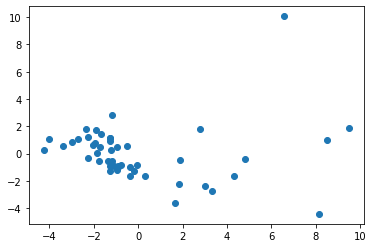

In [ ]:
plt.scatter(labels_reducted.T[0], labels_reducted.T[1])

In [ ]:
model_base_name = 'bert-large-uncased'
model_base = SentenceSimilarity(model_base_name)
model_base.compute_label_embedding(labels)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
labels_vector = model_base.label_embeds
pca.fit(labels_vector)
labels_reducted = pca.transform(labels_vector)
print(pca.explained_variance_ratio_)

[0.15568082 0.1241058 ]


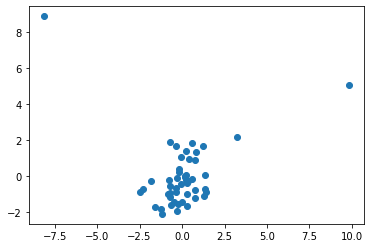

In [ ]:
plt.scatter(labels_reducted.T[0], labels_reducted.T[1])